In [22]:
import pandas as pd
import html
import re
import gensim
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from datetime import datetime


In [23]:
df = pd.read_csv("./extracted_data/compiled/data_clean_with_receiver_sender.csv")
df.head()

,i,0,dt,title,body,recipient,sender
0,0,Adzhubei__Aleksei,March_12__1962,Alexei Adzhubei s Account of His Visit to Wash...,"TOP SECRETDuring my visit to Washington, Brazi...",Washington,Alexei Adzhubei s Account
1,1,Albania__Ministry_of_Foreign_Affairs,March_15__1971,Notes on a Bulletin of the Korean News Agency 0,[Handwritten document] Note Looking at the bul...,NaN,the Korean News Agency
2,2,Alexandru__Boaba,April_06__1978,TELEGRAM 075 205 from the Romanian Embassy in ...,NaN,the Romanian Ministry of Foreign Affairs,TELEGRAM
3,3,Anda__Torleiv__1921-,October_21__1976,Telegram from the Embassy in Beijing Smuggli...,ROYAL MINISTRY OF FOREIGN AFFAIRSCOPY NO:1: MI...,NaN,Embassy
4,4,Anda__Torleiv__1921-,October_22__1976,Telegram from Norwegian Ambassador to China to...,"22.10.76, 09.34 amCOPY NO:1: MINISTER OF FOREI...",China,Norwegian


In [24]:
# original_date = df.iloc[0][2]
# dated = datetime.strptime(original_date, "%B_%d__%Y")
# print(dated.strftime("%Y%m%d"))

def parseDateTime(d):
    try:
        d = datetime.strptime(d, "%B_%d__%Y")
    except ValueError:
        return "20210101"
    return d.strftime("%Y%m%d")

parsed_datetime  = [parseDateTime(x) for x in df["dt"]]
df["date"] = parsed_datetime
df.head()

,i,0,dt,title,body,recipient,sender,date
0,0,Adzhubei__Aleksei,March_12__1962,Alexei Adzhubei s Account of His Visit to Wash...,"TOP SECRETDuring my visit to Washington, Brazi...",Washington,Alexei Adzhubei s Account,19620312
1,1,Albania__Ministry_of_Foreign_Affairs,March_15__1971,Notes on a Bulletin of the Korean News Agency 0,[Handwritten document] Note Looking at the bul...,NaN,the Korean News Agency,19710315
2,2,Alexandru__Boaba,April_06__1978,TELEGRAM 075 205 from the Romanian Embassy in ...,NaN,the Romanian Ministry of Foreign Affairs,TELEGRAM,19780406
3,3,Anda__Torleiv__1921-,October_21__1976,Telegram from the Embassy in Beijing Smuggli...,ROYAL MINISTRY OF FOREIGN AFFAIRSCOPY NO:1: MI...,NaN,Embassy,19761021
4,4,Anda__Torleiv__1921-,October_22__1976,Telegram from Norwegian Ambassador to China to...,"22.10.76, 09.34 amCOPY NO:1: MINISTER OF FOREI...",China,Norwegian,19761022


In [25]:
# df = pd.read_csv("./extracted_data/compiled/telegrams_with_extracted_receiver_sender.csv")
# df = df.drop([165, 273]) # 2 rows with incorrect dates
df['body'] = df['body'].astype(str)
df['datetime'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
start_date = '1945-08-14'
end_date = '1953-07-30'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df = df.loc[date_range] # choose relevant telegrams from the Korean war
df.head()

,i,0,dt,title,body,recipient,sender,date,datetime
5,5,Babkin,April_16__1952,Ciphered Telegram No 501587 Babkin to Shteme...,[…]CIPHERED TELEGRAM No. 501587From CORRESPOND...,Shtemenko,Babkin,19520416,1952-04-16
20,20,Bulganin__Nikolay_Aleksandrovich__1895-1975,October_02__1950,Telegram from Chanfu (Bulganin) to Matveyev (R...,Ciphered Note (by wire)To PYONGYANG MATVEYEV [...,Matveyev,Chanfu,19501002,1950-10-02
30,30,China__International_Liaison_Department,June_26__1951,Report from the Chinese International Liaison ...,Report: 1951 June 26 from the International De...,Ceasefire Negotiations,the Chinese International Liaison Department,19510626,1951-06-26
36,36,Chinese_Communist_Party_Central_Committee_(CCP...,December_08__1950,Draft Agreement by the Party Central Committee...,Ask Comrade Kim Il Sung for his opinion on the...,NaN,the Party Central Committee,19501208,1950-12-08
37,37,Chinese_Communist_Party_Central_Committee_(CCP...,July_11__1950,Telegram from the Chinese Communist Party Cent...,"Comrade Gao Gang, also to be passed on to Comr...",Gao Gang 0,the Chinese Communist Party Central Committee,19500711,1950-07-11


1945 - 1947: Initial Sentiments right after Japan surrendered

1948 - 1949: South Korea established

1950 - 1951: Korean War

1952 - 1953: Aftermath

In [26]:
def parse_and_train(given_df):
    long_sentences = []
    for index, row in given_df.iterrows():
        if len(row.body) > 0:
            sentences = row.body.split(".")
            for sentence in sentences:
                word_tokens = word_tokenize(sentence)
                filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
                final_sentence = " ".join(filtered_sentence)
                if len(final_sentence) > 4:
                    long_sentences.append(final_sentence)

    for sentence in long_sentences:
        yield gensim.utils.simple_preprocess (sentence)

In [19]:
start_date = '1950-09-01'
end_date = '1950-12-31'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df_1 = df.loc[date_range] 
print("Sept 1950 - Dec 1950: American Advance\nTelegrams available: ", len(df_1))

documents = []
documents.extend(list(parse_and_train(df_1)))

Sept 1950 - Dec 1950: American Advance
Telegrams available:  82


In [27]:
model = gensim.models.Word2Vec (documents, vector_size=150, window=5, min_count=2, workers=4)
model.train(documents,total_examples=len(documents),epochs=10)

(105690, 129360)

In [38]:
# search for similar words in the document
w1 = "moscow"
model.wv.most_similar(positive=w1)

[('cable', 0.19193486869335175),
 ('left', 0.18191255629062653),
 ('cities', 0.15997406840324402),
 ('bulganin', 0.15869741141796112),
 ('simultaneously', 0.1477995216846466),
 ('think', 0.14482909440994263),
 ('immediate', 0.1415518969297409),
 ('aforesaid', 0.13406550884246826),
 ('turned', 0.13273614645004272),
 ('boli', 0.11650580912828445)]

In [ ]:
model.wv.index_to_key[:100] # 100 most common words

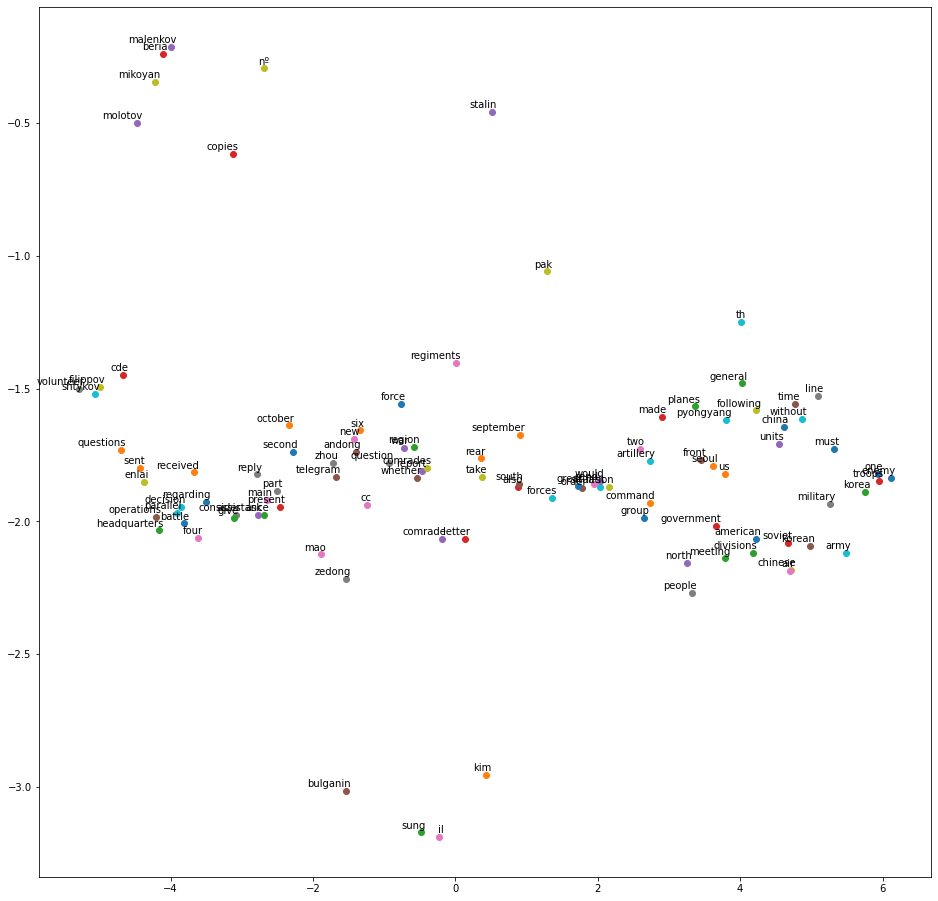

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    
#     fyi: to test specific labels instead of all the words in the vocab: 
    labels = ['china', 'us']
    tokens = []
    for label in labels: 
        tokens.append(model.wv[label])

    # labels = []
    # tokens = []
    

    # to speed up the process, let's limit to the first 100 elements
    count = 0
    for word in list(model.wv.key_to_index):
        if count < 100 and word not in labels:
            # store the word embeddings of the words 
            tokens.append(model.wv[word])
            # keep track of the labels too so that we can plot it in the graph below
            labels.append(word)
            count = count+1

    # define the parameters of the tsne model
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    
    # for the embeddings of our tokes to the tsne model
    new_values = tsne_model.fit_transform(tokens)


    # Now let's plot the tsne projects for each of the tokens in 2D
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(model)

May 1950 - Sep 1950: North Korea Strikes
Telegrams available:  48


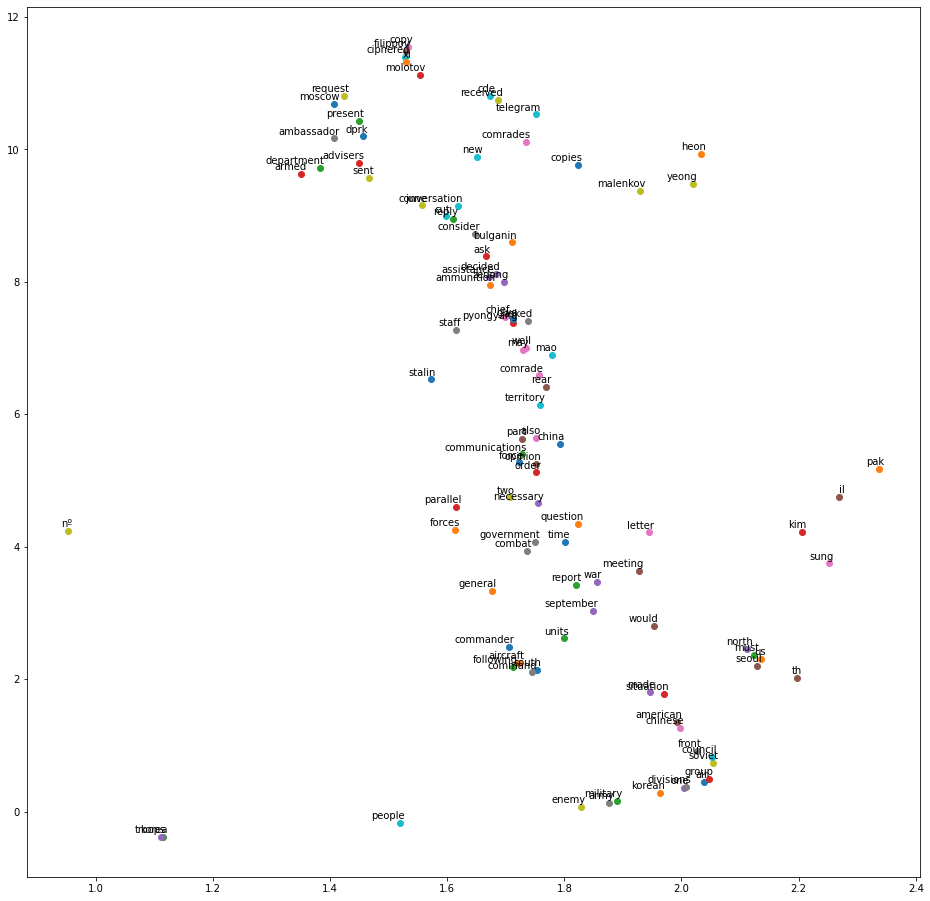

In [32]:
start_date = '1950-05-01'
end_date = '1950-09-30'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df_2 = df.loc[date_range] # choose relevant telegrams from the Korean war
df_2.head()
print("May 1950 - Sep 1950: North Korea Strikes\nTelegrams available: ", len(df_2))

documents = []
documents.extend(list(parse_and_train(df_2)))
model = gensim.models.Word2Vec (documents, vector_size=150, window=5, min_count=2, workers=4)
model.train(documents,total_examples=len(documents),epochs=10)
%matplotlib inline
tsne_plot(model)

Oct 1950 - Dec 1950: American Advance
Telegrams available:  61


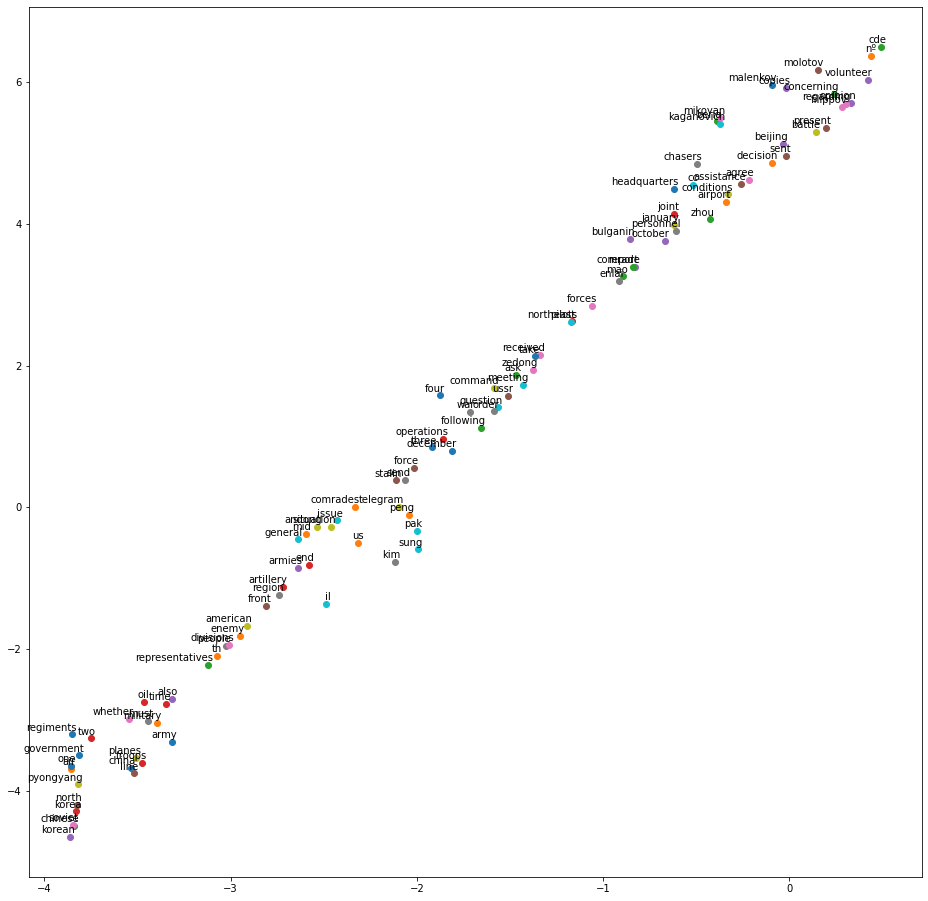

In [34]:
start_date = '1950-10-01'
end_date = '1950-12-31'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df_3 = df.loc[date_range] # choose relevant telegrams from the Korean war
print("Oct 1950 - Dec 1950: American Advance\nTelegrams available: ", len(df_3))

documents = []
documents.extend(list(parse_and_train(df_3)))
model = gensim.models.Word2Vec (documents, vector_size=150, window=5, min_count=2, workers=4)
model.train(documents,total_examples=len(documents),epochs=10)
tsne_plot(model)

1952 - 1953: Aftermath
Telegrams available:  95


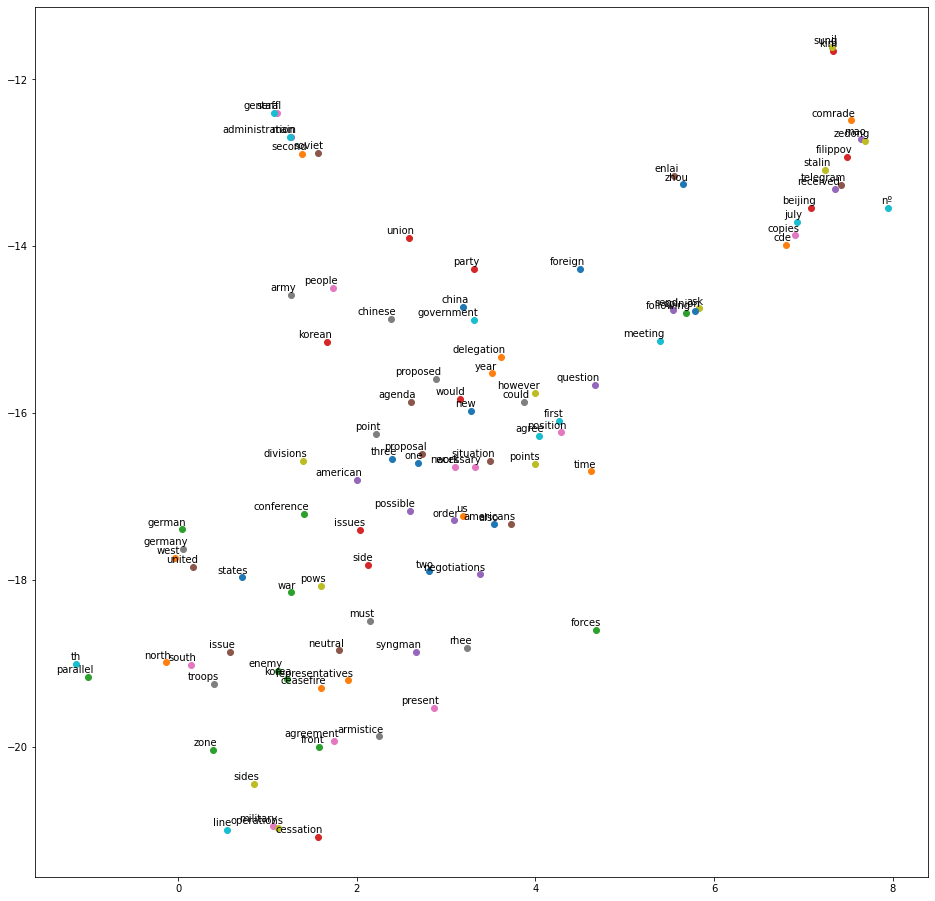

In [35]:
start_date = '1951-01-01'
end_date = '1953-07-30'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df_4 = df.loc[date_range] # choose relevant telegrams from the Korean war
print("1952 - 1953: Aftermath\nTelegrams available: ", len(df_4))

documents = []
documents.extend(list(parse_and_train(df_4)))
model = gensim.models.Word2Vec (documents, vector_size=150, window=5, min_count=2, workers=4)
model.train(documents,total_examples=len(documents),epochs=10)
tsne_plot(model)